# Utils

In [3]:
def print_list_nice(somelist):
    for thing in somelist:
        print(thing)

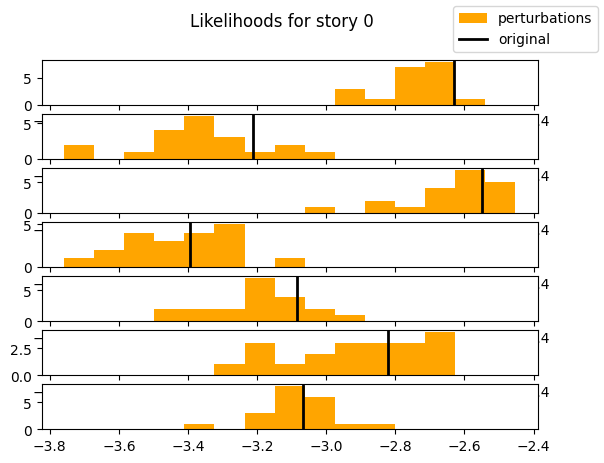

In [45]:
import numpy as np
import matplotlib.pyplot as plt
def hist_per_segment(storyname, pgrid_file, og_file):
    """
    @param pgrid_file: [String] a <NAME>_pgrid.npy file
    @param og_file: [String] a <NAME>_og.npy file
    """
    pgrid = np.load(pgrid_file)
    ll_og = np.load(og_file).squeeze()

    n_perturbs = pgrid.shape[0]
    n_segments = pgrid.shape[1]
    N_BINS_DESIRED = 15
    pgrid = pgrid[:,:n_segments]
    p_min = np.min(pgrid)
    p_max = np.max(pgrid)
    bins = np.linspace(p_min, p_max, N_BINS_DESIRED+1)

    fig, axs = plt.subplots(n_segments)
    
    for i in range(n_segments):
        axs[i].hist(pgrid[:,i], bins=bins, range=(p_min, p_max), label='perturbations', color='orange')
        axs[i].axvline(x=ll_og[i], linewidth=2, color='black', label='original')
        
    
    fig.suptitle(f"Likelihoods for story {storyname}")
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.show()

STORYNAME = "0"
PGRID_FILENAME = f"LLM_results/{STORYNAME}_pgrid.npy"
OG_FILENAME = f"LLM_results/{STORYNAME}_og.npy"

hist_per_segment(STORYNAME, PGRID_FILENAME, OG_FILENAME)

# Experiment 1
Idea is that there is some distribution of Z-scores ($\in [-\infty, \infty]$) for original likelihood w.r.t the distribution of perturbed likelihoods, across all segments.

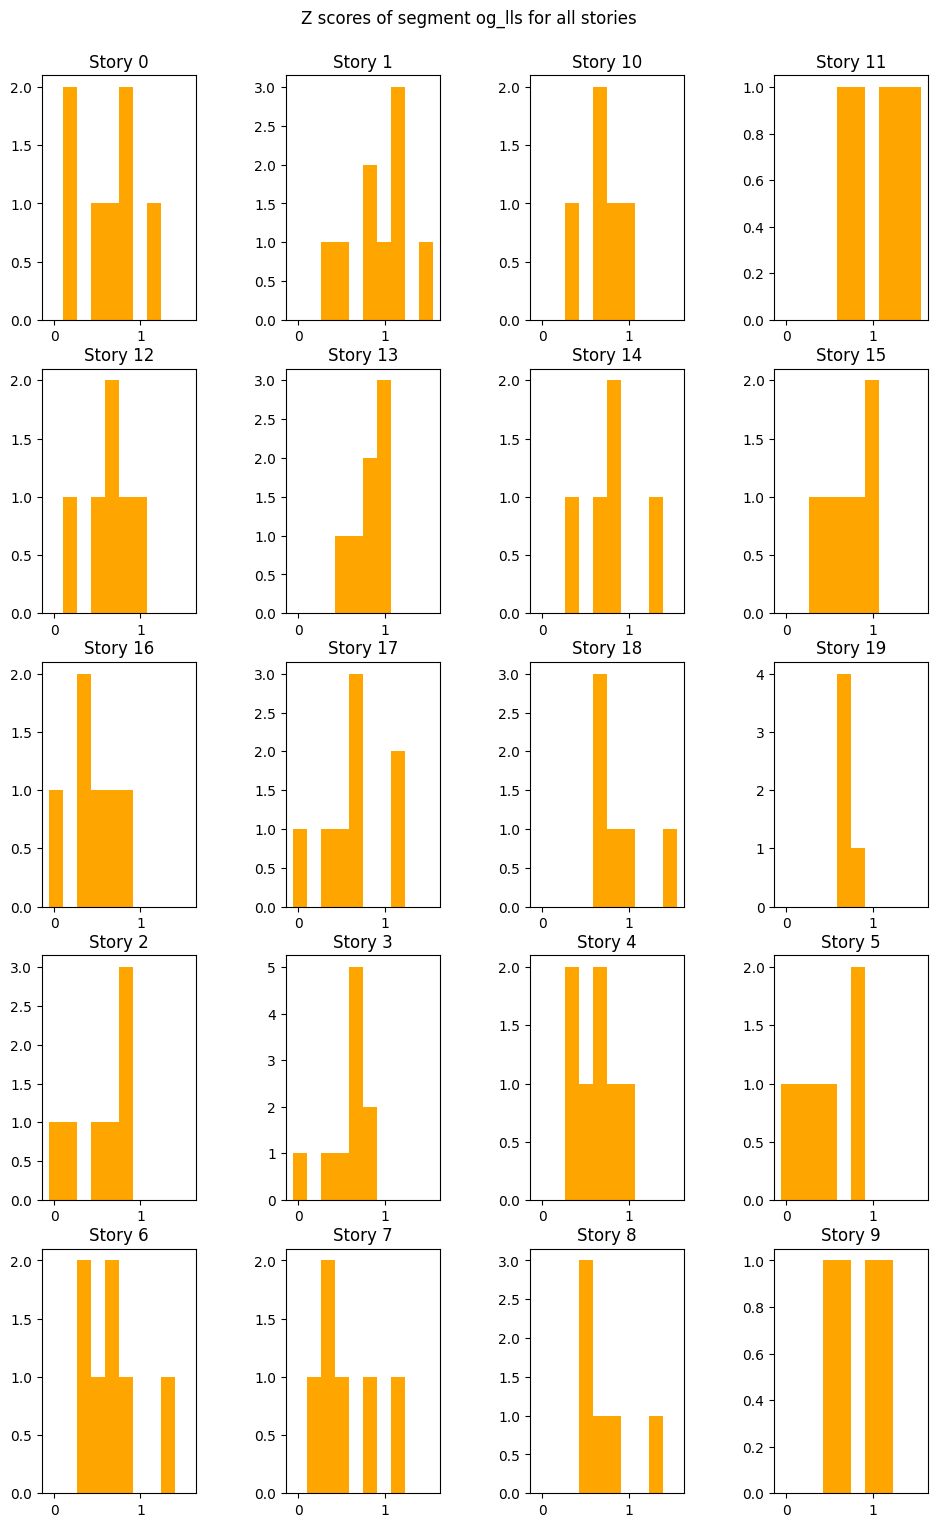

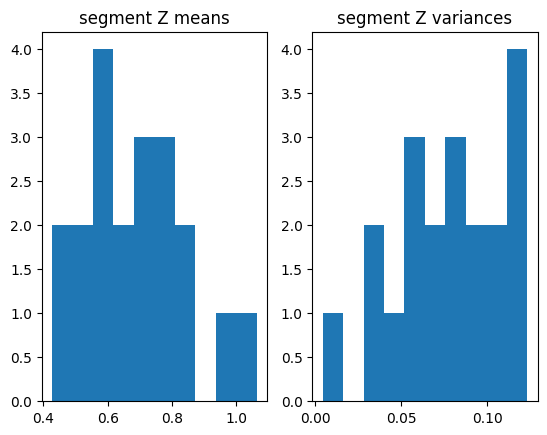

In [106]:
import os
import numpy as np

def load_data(folder, plt_top=1.0, plt_row_height=3.3, plot_save_loc=None, plot_name=None):
    """
    @param folder: [String] name of folder containing all the <NAME>_og.npy and <NAME>_pgrid.npy files.
    """ 
    all_files = os.listdir(folder)
    pgrid_files = [f"{folder}/{file}" for file in all_files if file.endswith('pgrid.npy')]
    og_files = [f"{folder}/{file}" for file in all_files if file.endswith('og.npy')]
    names = [f"{file[:-7]}" for file in all_files if file.endswith('og.npy')]
    pgrid_files.sort()
    og_files.sort()
    names.sort()
    
    all_pgrids = []
    all_og_lls = []
    
    # Load all the matrices
    for pgrid_file, og_file in zip(pgrid_files, og_files):
        pgrid = np.load(pgrid_file)
        og_ll = np.load(og_file).squeeze()
        all_pgrids.append(pgrid)
        all_og_lls.append(og_ll)
    
    # For each story, calculate segment-wise variance and mean across the perturbation likelihoods
    means = []
    variances = []
    for pgrid in all_pgrids:
        variances.append(np.var(pgrid, 0))  # Should get a (n_segment,) array
        means.append(np.mean(pgrid, 0))     # Should get a (n_segment,) array
    
    # Calculate Z score of the original ll w.r.t to the perturbation distributions
    Z_scores = []
    for story_idx, og_ll in enumerate(all_og_lls):
        Z = (og_ll - means[story_idx]) / np.sqrt(variances[story_idx])
        Z_scores.append(Z)
    
    # Compute segment_Z_means and segment_Z_vars for each story
    seg_Z_means = [np.mean(Z_score) for Z_score in Z_scores]
    seg_Z_vars = [np.var(Z_score) for Z_score in Z_scores]
    
    # Plot, for each story, a histogram of z scores.
    Z_min = np.min([np.min(Z_score) for Z_score in Z_scores]) 
    Z_max = np.max([np.max(Z_score) for Z_score in Z_scores])
    # Need to do this weird list iteration because Z_scores[i] aren't constant length
    bins = np.linspace(Z_min, Z_max)

    n_cols = 4

    n_rows = (len(Z_scores) + n_cols - 1) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols)
    fig.tight_layout()

    for i in range(len(Z_scores)):
        if n_rows == 1:
            axs[i].hist(Z_scores[i], range=(Z_min, Z_max), color='orange')
            axs[i].set_title(f'Story {names[i]}')
        else:
            axs[i // n_cols, i % n_cols].hist(Z_scores[i], range=(Z_min, Z_max), color='orange')
            axs[i // n_cols, i % n_cols].set_title(f'Story {names[i]}')

    fig.set_figwidth(10)
    fig.set_figheight(plt_row_height * n_rows)
    
    fig.suptitle(f"Z scores of segment og_lls for all stories")
    plt.subplots_adjust(top=plt_top, hspace=0.2)
    
    if plot_save_loc != None:
        plt.savefig(f"{plot_save_loc}/segment_zscore_hists_{plot_name}")
        
    plt.show()
    
    # Create a new figure with two subplots
    Z_fig, Z_axs = plt.subplots(1, 2)

    # Plot histogram of segment Z means
    Z_axs[0].hist(seg_Z_means)
    Z_axs[0].set_title('segment Z means')

    # Plot histogram of segment Z variances
    Z_axs[1].hist(seg_Z_vars)
    Z_axs[1].set_title('segment Z variances')
    
    if plot_save_loc != None:
        plt.savefig(f"{plot_save_loc}/segment_zscore_dists_{plot_name}")
        
    # Display the figure
    plt.show()

DATA_FOLDER = "LLM_results"
load_data(DATA_FOLDER, plt_top=0.94, plt_row_height=3.3, plot_save_loc="LLM_results", plot_name="prelim")

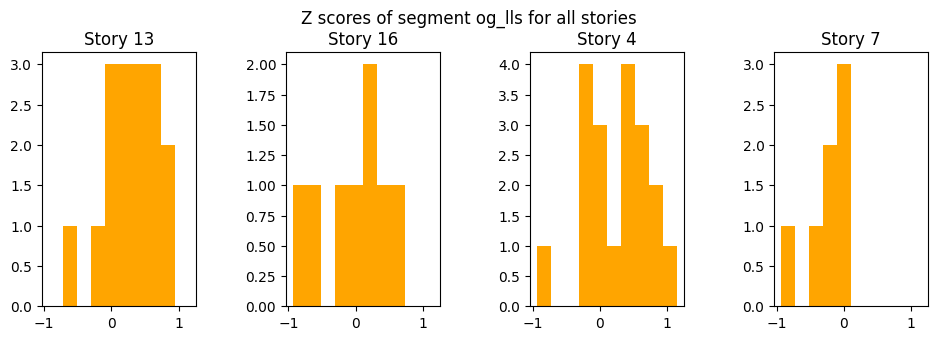

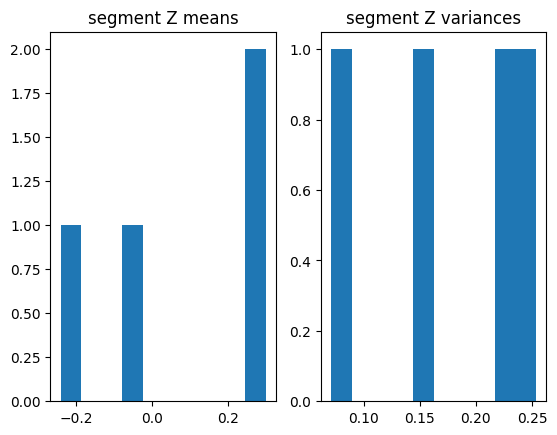

In [107]:

DATA_FOLDER = "human_results"
load_data(DATA_FOLDER, plt_top=0.85, plt_row_height=3.3, plot_save_loc="human_results", plot_name="human")